In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from matplotlib.collections import PatchCollection

In [6]:
def preprocessing(filename="data/value_policy.csv"):
    df_aux = pd.read_csv("data/episode.csv")
    episodes = len(df_aux)
    df = pd.read_csv(filename)
    states = len(df)//episodes
    df["State"] = [ i%states for i in range(episodes*states)]
    df["Episode"] = [i//states for i in range(episodes*states)]
    index = ['Episode', 'State']
    df.set_index(index, inplace=True)
    df = df.loc[(slice(None),[0,1,2,4,8,16]),:]
    return df

#Extract policy
def extract_policy(df, cols):
    d = df[cols]
    d = d.unstack("State")
    #Softmax
    m = d.mean(axis=1, level=1)
    d = d.subtract(m,axis=0)
    d = d.apply(np.exp)
    s = d.sum(axis=1, level=1)
    d = d.divide(s,axis=0)
    return d

def extract_value(df, col):
    d = df[col]
    d = d.unstack("State")
    return d

In [11]:
def animate_policy(birds_num=2):
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    sec_num = 6
    patches = []
    
    points = ax.scatter([], [], color="darkblue", s=5)

    # add the vision cone
    wedge = mpatches.Wedge((1, 1), 2, 0, 180, alpha=0.1, lw=1.5)
    patches.append(wedge)

    x = [2*math.cos(-math.pi/(sec_num-1)*i)+1 for i in range(1,sec_num-1)]
    y = [2*math.sin(math.pi/(sec_num-1)*i)+1 for i in range(1,sec_num-1)]

    for i in range(sec_num-2):
        ax.plot([1,x[i]],[1,y[i]], color="cornflowerblue", lw=0.3)
    
    t_p = np.array([[0,0], [1/2,math.sqrt(3)/2], [1,0]])*1/2  + np.array([3/4,1/2])
    
    # Simplex outside sectors
    t = mpatches.Polygon(t_p, alpha=0.2, lw=2)
    patches.append(t)
    
    t_coord = []
    
    for i in range(1,6):
        n_shift = 1.5*np.array([-math.cos(-i*math.pi/sec_num), math.sin(i*math.pi/sec_num)])
        t_coord.append(t_p + n_shift)
        t = mpatches.Polygon(t_coord[i-1], alpha=0.2, lw=2)
        patches.append(t)

    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    plt.axis('equal')
    plt.axis('off')
    t = plt.text(-1,3,"Episode 0")
    t.set_color('red')
    plt.tight_layout()
    
    #Data preparation
    df = preprocessing()
    df = extract_policy(df, ["left_0", "straight_0", "right_0"])
    df = df.loc[[i for i in range(0,len(df),100)]]
    df.reset_index(drop=True,inplace=True)
    x = (df[("right_0",)] - df[("left_0",)])/2 + 0.5
    y = df[("straight_0",)]*math.sqrt(3)/2
    sectors = [0,1,2,4,8,16]
    sec_num = len(df)
    
    def animate(i):
        p = np.empty([6,2])
        s_point = t_p[0] + np.array([x[0][i]/2, y[0][i]/2])
        p[0,:] = [s_point[0], s_point[1]]
        
        for j,k in enumerate(sectors[:0:-1]):
            s_point = t_coord[j] + np.array([x[k][i]/2, y[k][i]/2])
            p[j+1,:] = [s_point[0][0], s_point[0][1]]
            
        points.set_offsets(p)
        t.set_text("Episode "+str(i*100))
        if ((i*100)//2000)%birds_num == 0:
            t.set_color('red')
        else:
            t.set_color('blue')
        return points,t,

    anim = animation.FuncAnimation(fig, animate, frames=len(df), interval=20, blit=True)
    return anim

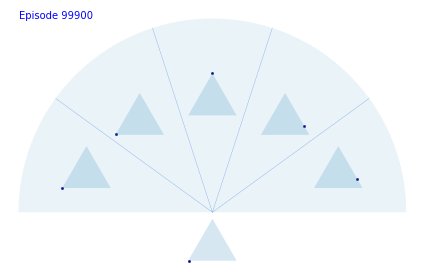

In [13]:
anim_p = animate_policy(birds_num=10)
HTML(anim_p.to_html5_video())